# Experiments Exploratory Data Analysis

## Simple setup
To use the `src` module inside of the notebooks:

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import janitor
import pandas as pd
import seaborn as sns

import src # Load custom functions.
sns.set_style("whitegrid")

## Load data

In [3]:
experiment_files = list(src.data_raw_dir().rglob("*.zip"))
experiment_ids = list(map(lambda x: x.stem, experiment_files)); experiment_ids

['plasmid_lineages', 'chromosome_lineages']

In [4]:
df = (
    src.read_experiments(
        experiment_files=experiment_files,
        experiment_ids=experiment_ids
    )
    .clean_experiment_names()
    .remove_columns(column_names="unnamed_0")
    .center_frames(by="experiment_id", frame_col="frame")
)
df.head()

,lineage_id,track_id,cell_id,mother_id,frame,roi_id,length,division,dead,gfp,dsred,file_name_id,experiment_id
0,0.0,10.8-34.0,10.8,10.8,0,roi_f10_n8_x129_y214,25.849682,0.0,0.0,120.110,108.394,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
1,0.0,10.8-34.0,11.6,10.8,1,roi_f11_n6_x126_y216,41.415207,1.0,0.0,120.289,108.422,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
2,0.0,10.8-34.0,12.8,10.8,2,roi_f12_n8_x122_y225,19.348009,0.0,0.0,119.765,107.959,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
3,0.0,10.8-34.0,13.8,10.8,3,roi_f13_n8_x124_y224,26.301427,0.0,0.0,119.771,108.061,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
4,0.0,10.8-34.0,14.5,10.8,4,roi_f14_n5_x124_y220,26.475045,0.0,0.0,119.718,107.977,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages


## Transform data

In [5]:
tidy_df = df.pivot_longer(column_names=["length", "gfp", "dsred"])

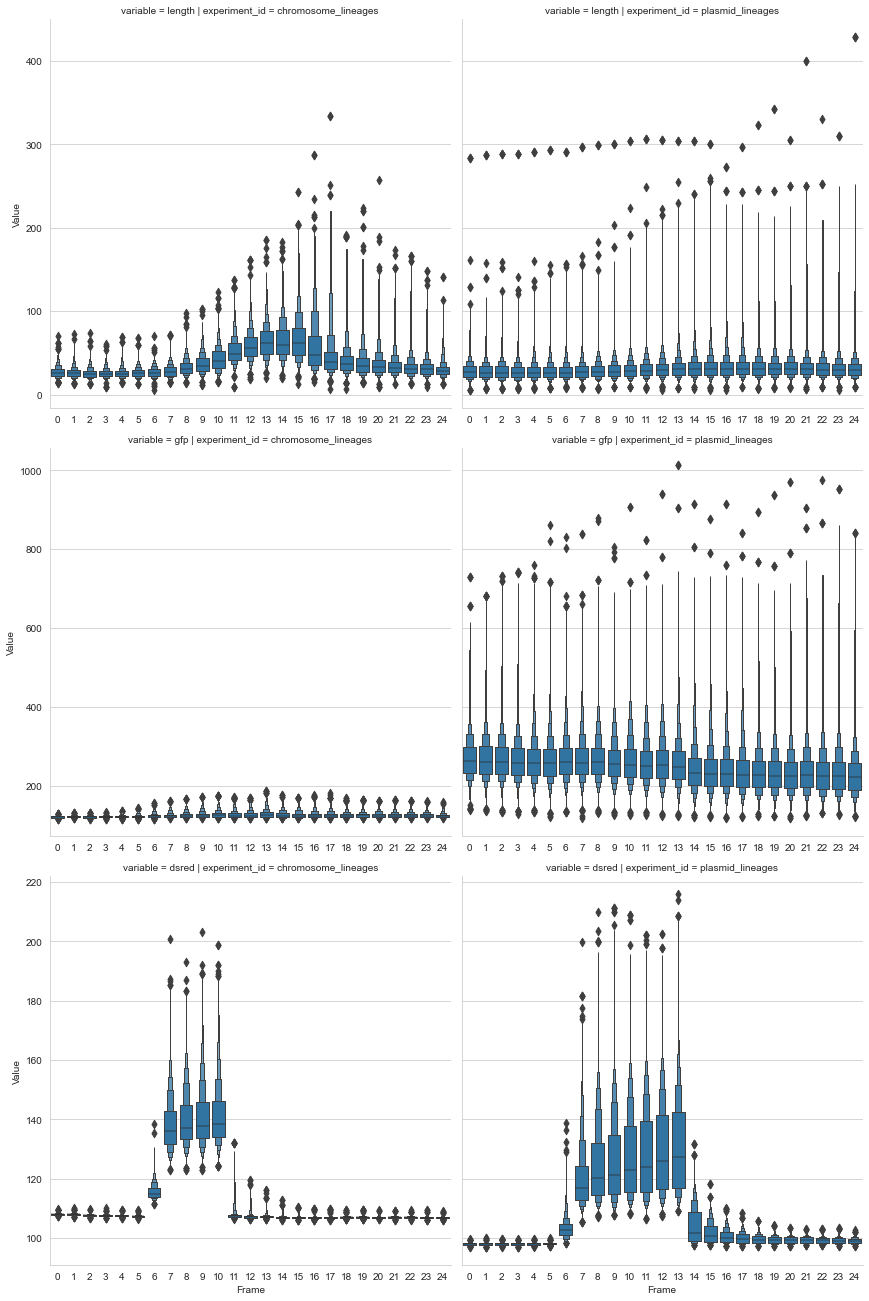

In [6]:
g = (
    sns.FacetGrid(
        data=tidy_df,
        row="variable",
        col="experiment_id",
        height=6,
        aspect=1.0,
        sharey="row",
        sharex=False
    )
    .map_dataframe(
        func=sns.boxenplot,
        x="frame",
        y="value"
    )
    .set_axis_labels("Frame", "Value")
    .savefig(src.reports_figures_dir("population_time_overview_boxplot.pdf"))
)